In [1]:
!nvidia-smi

Mon Aug 15 04:19:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 Do not run this unless required
 
 """!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/"""

In [2]:
!python3 -c 'import tensorflow as tf; print("Number of GPU : ",tf.config.list_physical_devices("GPU")) '

Number of GPU :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


!python3 -c 'import torch as tc; print("GPU available : ", tc.cuda.is_available())'

NLP problems are classified as sequence problems in the real worlds because the AI in
uses word embeddings or vectorised word to train on real world data and then classify textual matters

There are various types of sequence problems

![image.png](attachment:image.png)

Examples of some sequence problems

1.  Many to one - Sentiment Analysis like analysing comments on youtube section,Time series forecasting (like predicting the prices of Bitcoin)
2.  One to many - Image Captioning [Passing on an image and the resuly maybe a whole captioned images]
3.  Many to many - Google translate

# Todo update list
1. Dataset preprocessing - Done
2. Tokenization and embedding - 
3. RNN/CNN/Transfer-learning model setups
4. External model from Tfhub
5. Evaluation of the models
6. Prediction on custom data



# Inputs and outputs to an NLP problem statement
The inputs to an NLP problem is that a sequence of words are passed for example lets take an example of fake news related tweets classification , in this problem the tweets wold get numerical encoded which forms the input in a NLP model, because a Machine learning algorithm prefers values between 0 and 1 so it gets encoded in those ranges by tokenization and Character embedding . The output for this problem would be in probabilities like how much chance is there that it is a fake or how much chance is there
that it is real.

In simpler words what the machine basically uses is the #BATCH SIZE and the #Embedding_size [these vary as per the problem statement that we are handling].Batch size is basically partitioning the data into batches because for deep learning we need a GPU, and a GPU likes to work on batches on data rather than passing the dataset in one whole go.The embedding size is the size of the tensor because the tweet would be represented as tensor.And the ouputs would be the shape of the output tensor which is equal to the nos of classes the data is getting classified into like 2, 3, 4 ,5. In this case it's getting classified as 2 types like fake or real[this also varies as per your problem statement].

# Steps in modelling in Tensorflow
![Screenshot_2022-08-04-21-58-55_1920x1080.png](attachment:Screenshot_2022-08-04-21-58-55_1920x1080.png)

# Typical Architecture of Recurrent neural network

A recurrent neural network (RNN) is a class of artificial neural networks
where connections between nodes form a directed 
or undirected graph along a temporal sequence.

Basically it works on data with a temporal sequence that means a data which has a start 
and a end [Time series problem]

![Screenshot_2022-08-04-22-02-30_1920x1080.png](attachment:Screenshot_2022-08-04-22-02-30_1920x1080.png)



In [10]:
# My custom helper functions
# !wget https://raw.githubusercontent.com/Purbayan2014/Tensorflow-prac-scripts/master/Transfer-learning/Fine-Tuning/utils.py
# !wget https://raw.githubusercontent.com/Fishimal/Joint-Sentence-Classification-by-Neural-Networks/main/Reference-sec/train.csv

--2022-08-15 04:25:59--  https://raw.githubusercontent.com/Fishimal/Joint-Sentence-Classification-by-Neural-Networks/main/Reference-sec/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.007s  

2022-08-15 04:25:59 (127 MB/s) - ‘train.csv’ saved [987712/987712]



In [11]:
# Libraries used
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Input,LSTM,Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from utils import loss_plotter,image_preprocessor,pretty_matrix,pred_image_plt_plot,create_tensorboard_callback,histor_cmp,unzip_data,walker_dt_dir,evaluate_bin_class_model
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow_hub as hub
import random

In [12]:
# getting the dataset [kaggle's introduction to NLP dataset] binary classification
!ls -la

total 1408
drwxr-xr-x 1 root root   4096 Aug 15 04:25 .
drwxr-xr-x 1 root root   4096 Aug 15 04:15 ..
drwxr-xr-x 4 root root   4096 Aug  3 20:20 .config
drwxr-xr-x 2 root root   4096 Aug 15 04:20 __pycache__
drwxr-xr-x 1 root root   4096 Aug  3 20:21 sample_data
-rw-r--r-- 1 root root 420783 Aug 15 04:22 test.csv
-rw-r--r-- 1 root root 987712 Aug 15 04:25 train.csv
-rw-r--r-- 1 root root   6262 Aug 15 04:20 utils.py


In [13]:
# Visualizing the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [14]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [16]:
# TEXT is the tweets and the targets are the labels
# 1 is for disaster and 0 is for safe

# shuffling the dataset
train_df_sf = train_df.sample(frac=1,random_state=42)
train_df_sf.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [17]:
train_df.target.value_counts() # nos of examples in each classes

0    4342
1    3271
Name: target, dtype: int64

In [18]:
print('Nos of samples in the dataset :',len(train_df)+len(test_df))

Nos of samples in the dataset : 10876


In [19]:
# Visualizing on random samples
rand_index = random.randint(0, len(train_df)-5)
for row in train_df_sf[['text','target']][rand_index:rand_index+5].itertuples(): # grabbing 5 samples
    _, text,target = row
    print(f"Target : {target}", "(real disater)" if target > 0 else "(not a real disaster)")
    print(f"Text :\n{text}\n")
    print("---\n")

Target : 1 (real disater)
Text :
@themagickidraps not upset with a rally upset with burning buildings businesses executing cops that have nothing to do with it etc

---

Target : 1 (real disater)
Text :
Heat wave warning aa? Ayyo dei. Just when I plan to visit friends after a year.

---

Target : 1 (real disater)
Text :
Leeds fan.... rioting in Embra at a lower tier/ league cup final ... dee dum

---

Target : 0 (not a real disaster)
Text :
smoke good fuck eat drink drive nice car wear all green mink

---

Target : 1 (real disater)
Text :
@CyhiThePrynce bombed on Kanye in that #ElephantInTheRoom ????????

---



In [20]:
# Splitting the data into train and validation data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_sf['text'].to_numpy(),
                                                                           train_df_sf['target'].to_numpy(),
                                                                           test_size=0.1,
                                                                           random_state=42)

In [21]:
len(train_sentences),len(val_sentences),len(val_labels),len(train_labels)

(6851, 762, 762, 6851)

In [22]:
train_sentences[:10], train_labels[:10] # first 10 samples

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

![2022-08-04_22-59_1.png](attachment:2022-08-04_22-59_1.png)

# Text Vectorization(tokenization)

In [23]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [24]:
# # tf.keras.layers.TextVectorization(
# #     max_tokens=None,
# #     standardize='lower_and_strip_punctuation',
# #     split='whitespace',
# #     ngrams=None,
# #     output_mode='int',
# #     output_sequence_length=None,
# #     pad_to_max_tokens=False,
# #     vocabulary=None,
# #     idf_weights=None,
# #     sparse=False,
# #     ragged=False,
# #     **kwargs
# # )

# The processing of each example contains the following steps:

# Standardize each example (usually lowercasing + punctuation stripping)
# Split each example into substrings (usually words)
# Recombine substrings into tokens (usually ngrams)
# Index tokens (associate a unique int value with each token)
# # Transform each example using this index, either into a vector of ints or a dense float vector.

In [25]:
max_vocab_length = 10000 # max nos of words to have in our vocabulary
max_length = 15 # max length of our sequences will be ? (how many words from a tweet
# our model will see)

text_vectorizer =  TextVectorization(max_tokens=max_vocab_length, # how many group of words in the train sent
                                     # automatically figures out how many classes of words are there
                                     # and adds <OVV> which stands for out of vocabulary token
                                     # if max token in set 500 then it will pick out the most common 
                                     # 500 words that are found in the train dataset and rare words 
                                     # would get replaced by <OVV>
                                     standardize="lower_and_strip_punctuation", # convert to lowercase and remov ethe unusall data 
                                     split = "whitespace",
                                     ngrams=None, # create group of n words
                                     output_mode = "int", # how to map tokens to numbers
                                     output_sequence_length = max_length,# how long do we want our sequence of words to be
                                     pad_to_max_tokens = True # enabling padding for redundant chars in shorter words
                                    )

In [26]:
len(train_sentences[0].split())

7

In [27]:
# finding the average nos of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [28]:
# mapping the text vectorizer towards the train data
# fitting the text vectorizer to the train data
text_vectorizer.adapt(train_sentences)

In [29]:
# creating a sampling sentence and tokenize it
sample_sentence  = 'Wow I woke up on the wrong side of the bed , today i guess - Purbayan 2022'
sample_sentence_2 =  "NLP is not fun !!! "
text_vectorizer([sample_sentence]), text_vectorizer([sample_sentence_2])

(<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
 array([[ 970,    8, 1450,   27,   11,    2,  797,  668,    6,    2, 1040,
          124,    8, 1205,    1]])>,
 <tf.Tensor: shape=(1, 15), dtype=int64, numpy=
 array([[  1,   9,  34, 604,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]])>)

In [30]:
"""
970 - wow
1450 - I
woke - up
.... and so on

In the second mapping we can see a lot of 0 because the redundant characters got converted 
mapped into 0
"""
# choosing a random sentence and tokenize it
rand_sentence = random.choice(train_sentences)
print(f"Original sentence:\n {rand_sentence}\
        \n\nVectorized version:")
text_vectorizer([rand_sentence])

Original sentence:
 Lol meerkat is fucked. They will get demolished by periscope and Facebook live streaming.        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 174,    1,    9, 2986,   64,   38,   52,  606,   18, 9854,    7,
        1678,  199, 8032,    0]])>

In [31]:
# gettting the unique words in the training data
words_in_vocab = text_vectorizer.get_vocabulary() # getting all the unique words in the sentences
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # getting the least common words
print(f"5 Most common words in the vocab test : {top_5_words}")
print(f"5 Least common words in the vocab test : {bottom_5_words}")
print(f"Number of words in the vocab are {len(words_in_vocab)}")

# UNK stands for unknow that is basically the words that are out of the top 10000 words in the 
# dataset and is basically the OOV tokens

5 Most common words in the vocab test : ['', '[UNK]', 'the', 'a', 'in']
5 Least common words in the vocab test : ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']
Number of words in the vocab are 10000


In [32]:
### Creating an embedding layer 
"""
The common parameters that are used in the embedding layer :

1. input_dim = the size of the vocabulary
2. output_dim = the size of the output embedding vector example {
for a value of 100 would mean each token would get represented by a vector
of 100 long
3. input_length = length of the sequences being passed to the embedding layer

}

"""

'\nThe common parameters that are used in the embedding layer :\n\n1. input_dim = the size of the vocabulary\n2. output_dim = the size of the output embedding vector example {\nfor a value of 100 would mean each token would get represented by a vector\nof 100 long\n3. input_length = length of the sequences being passed to the embedding layer\n\n}\n\n'

In [33]:
"""
I used the output_dim 128 because the models that i will create will 
compute on GPU , it is said that a model performs well if its a 
multiple of 8 that is 8,64,128.. etc

"""

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                            output_dim = 128, # output_shape,
                            embeddings_initializer='uniform', # no need to understand this now ignore it
                            input_length=max_length,# how long the input
                            )
                        
    
# choosing a random sentence and tokenize it
rand_sentence = random.choice(train_sentences)
print(f"Original sentence:\n {rand_sentence}\
        \n\nEmbedded version:")

# embedding the random_sent into a dense vector of thick layer
sample_embed = embedding(text_vectorizer([rand_sentence]))
sample_embed 

Original sentence:
 (  the abomination that maketh desolate: The antichrist desecrates the Jerusalem temple - Dan 9:27 Matt 24:1  )        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03881355,  0.03633546,  0.04999275, ..., -0.02360059,
         -0.04532794,  0.0381296 ],
        [ 0.018192  ,  0.02169908,  0.04713352, ..., -0.02134473,
         -0.03387342, -0.00853316],
        [ 0.04941684,  0.02727452,  0.03218665, ..., -0.00866314,
         -0.02087098,  0.01789645],
        ...,
        [-0.00622132, -0.02835657, -0.04046688, ...,  0.00804846,
         -0.00807916, -0.03939103],
        [-0.00622132, -0.02835657, -0.04046688, ...,  0.00804846,
         -0.00807916, -0.03939103],
        [-0.00622132, -0.02835657, -0.04046688, ...,  0.00804846,
         -0.00807916, -0.03939103]]], dtype=float32)>

In [34]:
# The shape 1 , 15 , 128 is very important to understand
# 1 denotes that only a single token of sequence has been passed
# 15 denotes the nos of token generated from the sequence
# 128 denotes that all the tokens are in the format of 128 vector 

In [35]:
# checking out a single embedding
sample_embed[0][0] , sample_embed[0][0].shape, rand_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03881355,  0.03633546,  0.04999275, -0.04674962, -0.03033096,
        -0.03903051,  0.01085695,  0.01676876, -0.00143906,  0.03934363,
         0.00899734, -0.03351842, -0.03256162, -0.04672345,  0.02849466,
         0.01448083,  0.01918452, -0.04080654, -0.02099842,  0.04830371,
         0.00298209,  0.04679685, -0.00329584,  0.04667893, -0.04768844,
         0.01713395,  0.03689268, -0.04808423, -0.0233083 , -0.04993227,
         0.01763263, -0.00595236,  0.00397683,  0.04298833, -0.00935126,
         0.03253499, -0.01286596,  0.0432252 ,  0.01256785, -0.0138414 ,
         0.04638125,  0.04929627, -0.04482826,  0.04857859,  0.02651394,
        -0.03211591,  0.02226562,  0.04819863,  0.01102524, -0.02723528,
        -0.02748097, -0.04095291, -0.03784978, -0.03816434, -0.04802399,
         0.01189568, -0.03155446, -0.03777539, -0.02022904, -0.01200528,
        -0.03254817,  0.03715758,  0.03325654, -0.00542171, -0.04625536,
  

In [36]:
# In the above we can see the numerical 
# representation of the the sentence with the original sentence printed 
# below

In [37]:
# Modelling Experiments [TODO]

"""
0                  Naive Bayes with TF-IDF encoder(baseline model)
1                  Feed-forward neural network (dense model)
2                  LSTM(RNN) {Long Short Term Memory}
3                  GRU(RNN)  {Gated Reccurent Unit}
4                  Bidirectional-LSTM(RNN)
5                  1D Convulational Neural Network
6                  Tensorflow Hub Pretrained Feature Extractor
7                  Tensorflow Hub Pretrained Feature Extractor (10% of the data)

"""

'\n0                  Naive Bayes with TF-IDF encoder(baseline model)\n1                  Feed-forward neural network (dense model)\n2                  LSTM(RNN) {Long Short Term Memory}\n3                  GRU(RNN)  {Gated Reccurent Unit}\n4                  Bidirectional-LSTM(RNN)\n5                  1D Convulational Neural Network\n6                  Tensorflow Hub Pretrained Feature Extractor\n7                  Tensorflow Hub Pretrained Feature Extractor (10% of the data)\n\n'

In [38]:
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [39]:
# Model 0 Baseline Model 
# Naive Bayes with TF-IDF encoder 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# creating a tokenization and modelling pipeline
model_0 =  Pipeline([
    ("tfidf", TfidfVectorizer()), # convert the words into nos using tfidf
    ("clf", MultinomialNB()) # model the text clf stands for classifier
])

# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [40]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Accuracy of the baseline model : {baseline_score*100:.2f}%")

Accuracy of the baseline model : 79.27%


In [41]:
# make the predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

![Screenshot%20from%202022-08-06%2013-54-05.png](attachment:Screenshot%20from%202022-08-06%2013-54-05.png)

In [42]:
## Creating a evaluation func
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculate the evaluation metrics for a bin clf model
    """
    model_acc = accuracy_score(y_true,y_pred)*100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    model_results = {"accuracy" : model_acc,
                    "precision" : model_precision,
                    "recall" : model_recall,
                    "f1"   : model_f1}
    return model_results

In [43]:
# get the metrics

baseline_results = calculate_results(y_true=val_labels,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [44]:
# Model 1 Feed Forward Neural Network

# create a tensorboard callback
# create a directory to save the model logs
SAVE_DIR = "MODEL_LOGS"


# Buidling the model with functional API
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# Using the GlobalAvgPooling1D helps in ordering the dimensions 
# in the inputs that have been passed from layer to layer. 
# So at the end, you will have the shape (batch_size , 1 , features) 
# its more like using the Flatten layer except more efficient than 
# a Flatten layer. 
x = layers.GlobalAveragePooling1D()(x)
# x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = Model(inputs, outputs, name="model_1_dense")

In [45]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [46]:
# compile the model
model_1.compile(loss=BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

# fit the model
model_1_history = model_1.fit(x=train_sentences,
                             y=train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                  exp_name="model_1_dense")])


Gathering the log data and saving in : MODEL_LOGS/model_1_dense/20220815-042716
Epoch 1/5
215/215 [==============================] - 5s 5ms/step - loss: 0.6144 - accuracy: 0.6913 - val_loss: 0.5362 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4427 - accuracy: 0.8190 - val_loss: 0.4738 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3486 - accuracy: 0.8605 - val_loss: 0.4577 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2854 - accuracy: 0.8924 - val_loss: 0.4649 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2389 - accuracy: 0.9115 - val_loss: 0.4813 - val_accuracy: 0.7848


In [47]:
# check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4813 - accuracy: 0.7848


[0.48133042454719543, 0.7847769260406494]

In [48]:
# make some predictions and evaluate them
model_1_prd = model_1.predict(val_sentences)
model_1_prd[:10],model_1_prd[0],model_1_prd.shape

(array([[0.37378272],
        [0.74361724],
        [0.99702805],
        [0.10689031],
        [0.11412106],
        [0.9314799 ],
        [0.8883136 ],
        [0.9928831 ],
        [0.95468175],
        [0.27214718]], dtype=float32),
 array([0.37378272], dtype=float32),
 (762, 1))

In [49]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [50]:
# convert the model pred to the label format
# remove the single 1 dimension and round off the predictions
model_1_pred = tf.squeeze(tf.round(model_1_prd))
model_1_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [51]:
# Calculate the reuslts
model_1_res = calculate_results(val_labels,model_1_pred)
model_1_res

{'accuracy': 78.4776902887139,
 'f1': 0.7814477888250547,
 'precision': 0.7904782347685264,
 'recall': 0.7847769028871391}

In [52]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [53]:
import numpy as np
np.array(list(model_1_res.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [54]:
# We get four metrics that are higher than the deep learning  model

In [55]:
# Visualizing the model's learned word embeddings with Tensorflow's projector tool

# get the vocab from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [56]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [57]:
# get the weights matrix of the embedding layer
# (these are the numerical representations of each token in our training
# data for 5 epochs)

embedded_wts = model_1.get_layer("embedding").get_weights()[0]
embedded_wts.shape,embedded_wts

((10000, 128), array([[ 4.6393339e-02,  5.2824199e-02, -3.4395747e-02, ...,
         -1.9516451e-02,  2.5307145e-02, -7.3611327e-03],
        [ 2.0773679e-03, -1.6552858e-02, -4.7847278e-02, ...,
          6.7751214e-05, -1.2508793e-02, -3.7557229e-02],
        [-2.0812532e-02,  3.8452592e-02,  3.1964567e-02, ...,
         -4.1286115e-02, -6.1510846e-02,  5.8002815e-02],
        ...,
        [ 2.6486862e-02,  1.7524112e-02,  6.5533072e-04, ...,
         -8.8546984e-03, -4.5812190e-02, -4.5913376e-02],
        [ 6.0245086e-02, -1.5886154e-02, -8.3892941e-02, ...,
         -3.9881229e-02,  6.1770831e-03,  2.4584383e-03],
        [ 4.5699012e-02, -3.8835455e-02, -5.6964755e-02, ...,
         -9.1590896e-02, -1.0887840e-01,  5.0036062e-02]], dtype=float32))

In [58]:
# gets the all the wts in the embedded layer in the above cell

In [59]:
# Lets visualize the embedded weghts matrix
# https://www.tensorflow.org/text/guide/word_embeddings

# Create embedding files {we got this from the documentation}
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8') # vectors 
out_m = io.open('metadata.tsv', 'w', encoding='utf-8') # metadata that is the words

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedded_wts[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [60]:
# check the files
!ls

metadata.tsv  __pycache__  test.csv   utils.py
MODEL_LOGS    sample_data  train.csv  vectors.tsv


In [61]:
# word2vec
# https://www.tensorflow.org/tutorials/text/word2vec
# https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

# download the files if using a colab to the projector
# try:
#     from google.colab import files
#     files.download('vectors.tsv')
#     files.download('metadata.tsv')
# except Exception:
#     pass

# Load in the tsv files in https://projector.tensorflow.org/
# to visualize the weights

# https://jalammar.github.io/illustrated-word2vec/

![Screenshot%20from%202022-08-06%2015-28-13.png](attachment:Screenshot%20from%202022-08-06%2015-28-13.png)

# High level RNN's models


![0%20xs3Dya3qQBx6IU7C.png](attachment:0%20xs3Dya3qQBx6IU7C.png)

![1%20SKGAqkVVzT6co-sZ29ze-g.png](attachment:1%20SKGAqkVVzT6co-sZ29ze-g.png)

In [62]:
# let the T be the current time seq so its taking input 
# from the seq of t-1

# https://www.youtube.com/watch?v=QvkQ1B3FBqA&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2

In [63]:
# LSTM

# https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# http://karpathy.github.io/2015/05/21/rnn-effectiveness/

![Screenshot%20from%202022-08-06%2015-46-35.png](attachment:Screenshot%20from%202022-08-06%2015-46-35.png)

In [64]:
# Model 2 LSTM [RNN]
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape) # output of the embedding layer shape
x = layers.LSTM(64, return_sequences=True)(x) # 64 is the hidden units
print(x.shape) # shape of the lstm layer , we used return seq = true that's why the seq of the previous layer got repeated 
x = layers.LSTM(64)(x)
print(x.shape) 
x = layers.Dense(64, activation='relu')(x)
print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs, outputs,name='model_2_LSTM')

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 64)


In [65]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [66]:
# compile the model
model_2.compile(loss=BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

In [67]:
# fit the model
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_2_LSTM")])

Gathering the log data and saving in : MODEL_LOGS/model_2_LSTM/20220815-042729
Epoch 1/5
215/215 [==============================] - 10s 16ms/step - loss: 0.2218 - accuracy: 0.9219 - val_loss: 0.6001 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1581 - accuracy: 0.9425 - val_loss: 0.7111 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1265 - accuracy: 0.9510 - val_loss: 0.6858 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1087 - accuracy: 0.9575 - val_loss: 0.8468 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0842 - accuracy: 0.9653 - val_loss: 0.8209 - val_accuracy: 0.7664


In [68]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[4.5536426e-03],
       [6.3316560e-01],
       [9.9986339e-01],
       [5.4999337e-02],
       [3.4217024e-04],
       [9.9639219e-01],
       [4.3591651e-01],
       [9.9995780e-01],
       [9.9982482e-01],
       [3.6254627e-01]], dtype=float32)

In [69]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [70]:
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [71]:
# calculate the model 2 results

model_2_results = calculate_results(y_true=val_labels,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 76.64041994750657,
 'f1': 0.7600744655442512,
 'precision': 0.7790315580631162,
 'recall': 0.7664041994750657}

In [72]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [73]:
# It still seems that the baseline model is performing better than
# the LSTM model

In [74]:
!ls -la

total 16516
drwxr-xr-x 1 root root     4096 Aug 15 04:27 .
drwxr-xr-x 1 root root     4096 Aug 15 04:15 ..
drwxr-xr-x 4 root root     4096 Aug  3 20:20 .config
-rw-r--r-- 1 root root    80388 Aug 15 04:27 metadata.tsv
drwxr-xr-x 4 root root     4096 Aug 15 04:27 MODEL_LOGS
drwxr-xr-x 2 root root     4096 Aug 15 04:20 __pycache__
drwxr-xr-x 1 root root     4096 Aug  3 20:21 sample_data
-rw-r--r-- 1 root root   420783 Aug 15 04:22 test.csv
-rw-r--r-- 1 root root   987712 Aug 15 04:25 train.csv
-rw-r--r-- 1 root root     6262 Aug 15 04:20 utils.py
-rw-r--r-- 1 root root 15384222 Aug 15 04:27 vectors.tsv


In [75]:
# Model 3

# GRU MODEL -- Gated recurrent network
"""
It is a popular and effective RNN component is, it has similar features
to an LSTM cell but has less parameters.
"""

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# return seq is same as the earlier model func like stacking 
# the prev layers on top of each other 
x = layers.GRU(64)(x)
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = Model(inputs,outputs,name="model_3_GRU")

In [76]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                       

In [77]:
model_3.compile(loss=BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])


model_3_history = model_3.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3_gru")])

Gathering the log data and saving in : MODEL_LOGS/model_3_gru/20220815-042754
Epoch 1/5
215/215 [==============================] - 3s 9ms/step - loss: 0.6466 - accuracy: 0.9038 - val_loss: 0.6473 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.5929 - accuracy: 0.9656 - val_loss: 0.6253 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.5499 - accuracy: 0.9672 - val_loss: 0.6013 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.5111 - accuracy: 0.9693 - val_loss: 0.5905 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4776 - accuracy: 0.9676 - val_loss: 0.5758 - val_accuracy: 0.7717


In [78]:
model_3_pred = model_3.predict(val_sentences)
model_3_pred

array([[0.35317647],
       [0.6356186 ],
       [0.6356187 ],
       [0.35229355],
       [0.35229313],
       [0.6355177 ],
       [0.36782774],
       [0.6356187 ],
       [0.6356187 ],
       [0.3639078 ],
       [0.3522932 ],
       [0.6356075 ],
       [0.35229367],
       [0.3522956 ],
       [0.3522931 ],
       [0.35229963],
       [0.35229313],
       [0.3522932 ],
       [0.3522938 ],
       [0.6356171 ],
       [0.63561857],
       [0.35229313],
       [0.6299354 ],
       [0.3522942 ],
       [0.6356187 ],
       [0.6356187 ],
       [0.35229325],
       [0.35229334],
       [0.35229313],
       [0.35694662],
       [0.52425057],
       [0.35229325],
       [0.40422267],
       [0.35229394],
       [0.5020916 ],
       [0.35229418],
       [0.6356187 ],
       [0.352299  ],
       [0.35229325],
       [0.6356187 ],
       [0.35486057],
       [0.35229313],
       [0.35371193],
       [0.35229313],
       [0.6354311 ],
       [0.6356187 ],
       [0.6356175 ],
       [0.635

In [79]:
# covert the preds to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [80]:
model_3_results = calculate_results(val_labels,
                                   model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'f1': 0.7681214344851189,
 'precision': 0.7767213938683196,
 'recall': 0.7716535433070866}

In [81]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [82]:
# Still hasnt beaten the baseline results

![779461812-1b9c99e2155f995d_articlex-1200599870.png](attachment:779461812-1b9c99e2155f995d_articlex-1200599870.png)

In [83]:
# Model 4 
# Bidirectional LSTM(RNN)

"""
Unidirectional --> left to right
Bidirectional --> left to right and right to left
"""
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True)(x))
x = layers.Bidirectional(layers.GRU(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = Model(inputs,outputs, name="model_4_bidirectional_RNN")


# compile the model
model_4.compile(loss=BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

# fit the model
model_4_his = model_4.fit(train_sentences,
                         train_labels,
                         epochs=5,
                         validation_data=(val_sentences,val_labels),
                         callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_callback")])

Gathering the log data and saving in : MODEL_LOGS/model_4_callback/20220815-042804
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1444 - accuracy: 0.9575 - val_loss: 0.6061 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0813 - accuracy: 0.9733 - val_loss: 0.7048 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0663 - accuracy: 0.9765 - val_loss: 0.9992 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0562 - accuracy: 0.9761 - val_loss: 1.0979 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0489 - accuracy: 0.9783 - val_loss: 1.0328 - val_accuracy: 0.7677


In [84]:
# grab the predictions
model_4_pred = model_4.predict(val_sentences)
model_4_pred = tf.squeeze(tf.round(model_4_pred))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [85]:
model_4_res = calculate_results(val_labels,model_4_pred)
model_4_res

{'accuracy': 76.77165354330708,
 'f1': 0.7638693672676267,
 'precision': 0.7732501179288073,
 'recall': 0.7677165354330708}

In [86]:
model_3_results

{'accuracy': 77.16535433070865,
 'f1': 0.7681214344851189,
 'precision': 0.7767213938683196,
 'recall': 0.7716535433070866}

In [87]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [88]:
# Even worse than the base and the LSTM model

![Screenshot_2022-08-15-07-10-12_1920x1080.png](attachment:Screenshot_2022-08-15-07-10-12_1920x1080.png)

In [89]:
# Model_5_experimental model
# 1D ConvNet

# Testing out a embedding layer, conv1d layer and max pooling

embedding_test = embedding(text_vectorizer(["This is a test sentence"]))
conv1D =  layers.Conv1D(filters=64,
                       kernel_size=5, # referred to as the ngram(of 5) means it looks at 5 words at a time
                       activation="relu",
                       strides=1, # if set to 2 or more it will hop 2 or x more words at a time
                       padding="same") # valid's output is smaller than the input shape
                                        # same's output is similar to the output of the input shape
"""
https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
"""
    
conv1D_output = conv1D(embedding_test) # pass the embedding test
max_pool = layers.GlobalMaxPool1D()
max_pool_ouput = max_pool(conv1D_output) # get the most important features

embedding_test.shape, conv1D_output.shape, max_pool_ouput.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [90]:
"""

TensorShape([1, 15, 128]) ---> 1 because of the  output from embedding test layer
(1 sequence that is 1 test sentence) and 15 because of the nos of tokens 
it has formed and 128 is the feature vector 
that is each of the tokens is encoded in a 128 feature vector

TensorShape([1, 11, 32]) --> 11 because , the parameter {padding="valid"} compresses the 
nos of tokens from 15 to 11 if it has been enabled with same then it would have compressed 
from 15 to 15 , and 32 is the nos of filters basically the nos of hidden layers or the 
filters that is 32 .

TensorShape([1, 32] --> After passing through the maxpooling layer , it takes the max of 
everything and returns them as one big feature feature vector that is 32.


"""

# https://poloclub.github.io/cnn-explainer/

'\n\nTensorShape([1, 15, 128]) ---> 1 because of the  output from embedding test layer\n(1 sequence that is 1 test sentence) and 15 because of the nos of tokens \nit has formed and 128 is the feature vector \nthat is each of the tokens is encoded in a 128 feature vector\n\nTensorShape([1, 11, 32]) --> 11 because , the parameter {padding="valid"} compresses the \nnos of tokens from 15 to 11 if it has been enabled with same then it would have compressed \nfrom 15 to 15 , and 32 is the nos of filters basically the nos of hidden layers or the \nfilters that is 32 .\n\nTensorShape([1, 32] --> After passing through the maxpooling layer , it takes the max of \neverything and returns them as one big feature feature vector that is 32.\n\n\n'


Since our kernel size is set to 5 it looks at 5 words at a time and grabs them as 1 whole
token "I am sitting with my laptop", ... and so on



In [91]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0494133 ,  0.07324515, -0.02222492, ..., -0.02968419,
          0.0210688 , -0.07577949],
        [-0.00215471, -0.02070585, -0.04991289, ..., -0.01498617,
         -0.02370007, -0.0393953 ],
        [-0.02172324,  0.04207642,  0.02680686, ..., -0.01126337,
          0.00861913,  0.03465757],
        ...,
        [ 0.00543108,  0.0204725 , -0.02433044, ..., -0.02532583,
          0.01888749, -0.02989858],
        [ 0.00543108,  0.0204725 , -0.02433044, ..., -0.02532583,
          0.01888749, -0.02989858],
        [ 0.00543108,  0.0204725 , -0.02433044, ..., -0.02532583,
          0.01888749, -0.02989858]]], dtype=float32)>

In [92]:
conv1D_output

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[0.01849133, 0.0102237 , 0.        , 0.02096596, 0.07753639,
         0.00930906, 0.02386604, 0.05250021, 0.        , 0.        ,
         0.        , 0.00605211, 0.0354613 , 0.        , 0.        ,
         0.01374231, 0.01504876, 0.02114988, 0.        , 0.        ,
         0.        , 0.        , 0.02227503, 0.03713014, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.03149579,
         0.        , 0.01671756, 0.        , 0.        , 0.        ,
         0.01243779, 0.        , 0.        , 0.        , 0.05129534,
         0.00944006, 0.01456986, 0.02130339, 0.0163785 , 0.01907432,
         0.        , 0.        , 0.00632061, 0.        , 0.05157971,
         0.        , 0.        , 0.        , 0.        , 0.02865427,
         0.        , 0.00255462, 0.00674929, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.08438832, 0.03098045, 0.        , 0.01

In [93]:
max_pool_ouput

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.01849133, 0.08438832, 0.05716361, 0.02096596, 0.07753639,
        0.02209577, 0.02978086, 0.05250021, 0.03675921, 0.04133658,
        0.        , 0.05763614, 0.10187194, 0.09171575, 0.07109867,
        0.05025939, 0.0643848 , 0.05478267, 0.06145947, 0.03983498,
        0.03590716, 0.01209273, 0.06788908, 0.08289178, 0.03067352,
        0.08155043, 0.01374073, 0.04894731, 0.05285533, 0.07347141,
        0.02548302, 0.03899568, 0.03952502, 0.02170202, 0.09356886,
        0.03672349, 0.        , 0.04945873, 0.0084636 , 0.07661867,
        0.0725276 , 0.04083464, 0.02130339, 0.09000228, 0.02410698,
        0.03367116, 0.04969554, 0.06915972, 0.05882328, 0.05157971,
        0.10141737, 0.05240486, 0.06056199, 0.0419757 , 0.08879949,
        0.03109953, 0.03406154, 0.06213633, 0.04202716, 0.06454972,
        0.00774013, 0.        , 0.046863  , 0.02313853]], dtype=float32)>

In [94]:
# Model_5
# Conv1D model

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                 strides=1,
                 kernel_size=5,
                 activation="relu",
                 padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(1,activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = Model(inputs, outputs,name="model_5_Conv1D")

model_5.compile(loss=BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

model_5_history = model_5.fit(train_sentences,
                             train_labels,
                             validation_data=(val_sentences, val_labels),
                             epochs=5,
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_Conv1D")])

Gathering the log data and saving in : MODEL_LOGS/model_5_Conv1D/20220815-042824
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.1279 - accuracy: 0.9552 - val_loss: 0.8691 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0776 - accuracy: 0.9718 - val_loss: 0.9906 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0640 - accuracy: 0.9747 - val_loss: 1.1296 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0598 - accuracy: 0.9752 - val_loss: 1.1468 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0531 - accuracy: 0.9777 - val_loss: 1.2101 - val_accuracy: 0.7559


In [95]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)              

In [96]:
# grab the predictions
model_5_preds = model_5.predict(val_sentences)
model_5_preds[:10]

array([[1.2504974e-01],
       [4.5287544e-01],
       [9.9994230e-01],
       [4.3975469e-02],
       [2.1187208e-07],
       [9.9200201e-01],
       [9.1870999e-01],
       [9.9982208e-01],
       [9.9999619e-01],
       [8.7311828e-01]], dtype=float32)

In [97]:
model_5_preds = tf.squeeze(tf.round(model_5_preds))
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'f1': 0.7536918613918199,
 'precision': 0.7571361526829015,
 'recall': 0.7559055118110236}

In [98]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [99]:
# Still cant beat the baseline model

In [101]:
# Model_6
# Transfer learning Models
# TF Hub Pretrained Feature Extractor model

#     USE feature extractor model [Universal Feature Encoder]

# Model link ---> https://tfhub.dev/google/collections/universal-sentence-encoder/1
# 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# 

# embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)
embed_samples = embed([sample_sentence,
                      "When you can the univrsal sentence encoder on a sentence, it turns it into numbers."])
# embed_samples = embed([sample_sentence,
#                        "Wow, I still have to study and work at the same time geez"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01443893 -0.00599039 -0.04559013  0.04534918 -0.02062652  0.01393014
 -0.06905753  0.04280511  0.02126483  0.04248023 -0.04659408  0.07505151
 -0.01405933  0.01019932  0.05304514 -0.02879466 -0.05050775 -0.00089983
  0.00952864 -0.03611656 -0.0110835  -0.02132455  0.0691835  -0.05194677
  0.07864773 -0.00116064  0.08336279  0.06056589 -0.01787721 -0.02085744
 -0.01772531  0.00146203  0.08770007 -0.07025129 -0.05233978  0.0097592
  0.02252566  0.06257525  0.04666005  0.04641011  0.05046926 -0.04574616
 -0.0330748   0.02150823 -0.01423052 -0.01759312 -0.09435947  0.10395356
  0.04582724 -0.00912383], shape=(50,), dtype=float32)


In [104]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01443893, -0.00599039, -0.04559013, ..., -0.02473616,
         0.06314445,  0.02400106],
       [ 0.02917226, -0.09069518,  0.00653531, ..., -0.02631373,
         0.00687158,  0.0003924 ]], dtype=float32)>

In [105]:
embed_samples[0].shape

TensorShape([512])

In [120]:
# Creating a layer using the USE pre trained layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string, 
                                        trainable=False,
                                        name="USE_model")

# Create model using the sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
], name="model_6_USE")

# compile
model_6.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

model_6.summary()


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_model (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [121]:
# MODEL fit
model_6.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,"model_6_USE")])

Gathering the log data and saving in : MODEL_LOGS/model_6_USE/20220815-053930
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5072 - accuracy: 0.7907 - val_loss: 0.4450 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4138 - accuracy: 0.8142 - val_loss: 0.4386 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3999 - accuracy: 0.8225 - val_loss: 0.4299 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3912 - accuracy: 0.8269 - val_loss: 0.4326 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3856 - accuracy: 0.8305 - val_loss: 0.4252 - val_accuracy: 0.8163


In [122]:
# predict
model_6_preds = model_6.predict(val_sentences)
model_6_preds[:10]

array([[0.19333024],
       [0.7689675 ],
       [0.98782223],
       [0.2127085 ],
       [0.7597406 ],
       [0.7829812 ],
       [0.9852887 ],
       [0.98456776],
       [0.9290282 ],
       [0.11194909]], dtype=float32)

In [123]:
model_6_preds = tf.squeeze(tf.round(model_6_preds))
model_6_res = calculate_results(val_labels, model_6_preds)
model_6_res

{'accuracy': 81.62729658792651,
 'f1': 0.8151782870321896,
 'precision': 0.8174065945777478,
 'recall': 0.8162729658792651}

In [124]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [125]:
# At last beats the baseline_results

In [127]:
# Model_7
# Same as model_6 with 10% of the data
# frac means the percent of data used for train
# Making splits like this leads to data leakage

# train_10_per = train_df_sf[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_per.head(), len(train_10_per)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1, 761)

In [128]:
# len(train_df_sf)

7613

In [130]:
# train_sentences_10_percent = train_10_per["text"].to_list()
# train_labels_10_percent = train_10_per["target"].to_list()

# len(train_df_sf)

7613

In [147]:
# Correct way to do the splits 
train_sentences_10_split = int(0.1 *  len(train_sentences))
train_sentences_10 = train_sentences[:train_sentences_10_split]
# len(train_sentences_10)
train_labels_10 = train_labels[:train_sentences_10_split]

In [148]:
len(train_sentences_10), len(train_labels_10)

(685, 685)

In [132]:
train_df_sf["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [152]:
# train_sentences_10["target"].value_counts()
pd.Series(np.array(train_labels_10)).value_counts()

0    406
1    279
dtype: int64

In [153]:
# Building model 7

"""
We can use the Models.clone_model()

https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model
"""

model_7 = tf.keras.models.clone_model(model_6)

# compile model
model_7.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# fit model
model_7_history = model_7.fit(train_sentences_10,
            train_labels_10,
            validation_data=(val_sentences, val_labels),
            epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_7_model6_10_percent")])
# summary
model_7.summary()


Gathering the log data and saving in : MODEL_LOGS/model_7_model6_10_percent/20220815-065130
Epoch 1/5
22/22 [==============================] - 3s 43ms/step - loss: 0.6687 - accuracy: 0.6234 - val_loss: 0.6511 - val_accuracy: 0.6824
Epoch 2/5
22/22 [==============================] - 0s 21ms/step - loss: 0.6015 - accuracy: 0.7854 - val_loss: 0.5981 - val_accuracy: 0.7507
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5273 - accuracy: 0.8175 - val_loss: 0.5405 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4643 - accuracy: 0.8204 - val_loss: 0.5078 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4220 - accuracy: 0.8321 - val_loss: 0.4890 - val_accuracy: 0.7795
Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_model (KerasLayer)      (None, 512)               

In [157]:
# Calculate the results
model_7_prds = model_7.predict(val_sentences)
model_7_prds[:10]

model_7_preds = tf.squeeze(tf.round(model_7_prds))
model_7_results =  calculate_results(val_labels, model_7_preds)

In [158]:
model_7_results 

{'accuracy': 77.95275590551181,
 'f1': 0.7783167829714759,
 'precision': 0.7799065773530309,
 'recall': 0.7795275590551181}

In [159]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [161]:
model_6_res

{'accuracy': 81.62729658792651,
 'f1': 0.8151782870321896,
 'precision': 0.8174065945777478,
 'recall': 0.8162729658792651}

In [160]:
# Why our model is performing better than 10 % of the data ?
# We gotta debug

# Update --> Finally we fixed the leakage 

In [ ]:
"""
Some of the validation data is already present in the train_sentences_10_percent 
thats why we want to fix to this , this is causing a data leakage
"""



In [170]:
all_model_results= pd.DataFrame({
    "Base-line_res" : baseline_results,
    "Feed-Forward-Network": model_1_res,
    "LSTM(RNN)": model_2_results,
    "GRU(RNN)": model_3_results,
    "Bidirectional_RNN": model_4_res,
    "Conv1D": model_5_results,
    "USE_model":model_6_res,
    "USE_model_10%":model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Base-line_res,79.265092,0.811139,0.792651,0.786219
Feed-Forward-Network,78.477690,0.790478,0.784777,0.781448
LSTM(RNN),76.640420,0.779032,0.766404,0.760074
GRU(RNN),77.165354,0.776721,0.771654,0.768121
Bidirectional_RNN,76.771654,0.773250,0.767717,0.763869
Conv1D,75.590551,0.757136,0.755906,0.753692
USE_model,81.627297,0.817407,0.816273,0.815178
USE_model_10%,77.952756,0.779907,0.779528,0.778317


In [172]:
# Reduce the accuracy to the same scale as other metrics
# all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
Base-line_res,0.792651,0.811139,0.792651,0.786219
Feed-Forward-Network,0.784777,0.790478,0.784777,0.781448
LSTM(RNN),0.766404,0.779032,0.766404,0.760074
GRU(RNN),0.771654,0.776721,0.771654,0.768121
Bidirectional_RNN,0.767717,0.773250,0.767717,0.763869
Conv1D,0.755906,0.757136,0.755906,0.753692
USE_model,0.816273,0.817407,0.816273,0.815178
USE_model_10%,0.779528,0.779907,0.779528,0.778317


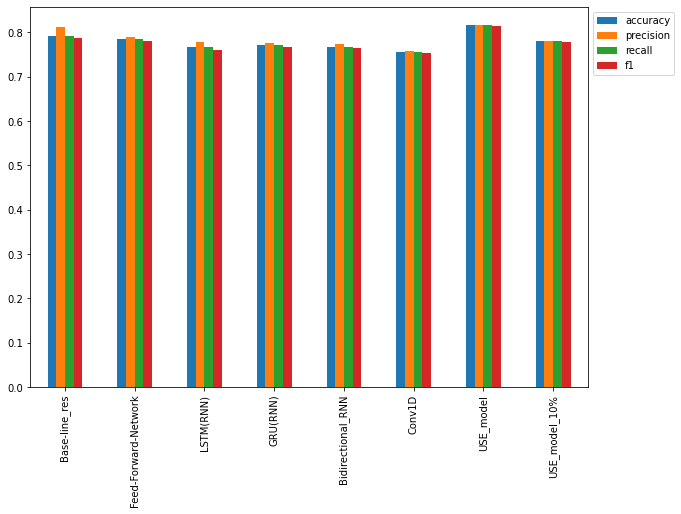

In [174]:
# Plot and compare all the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0))

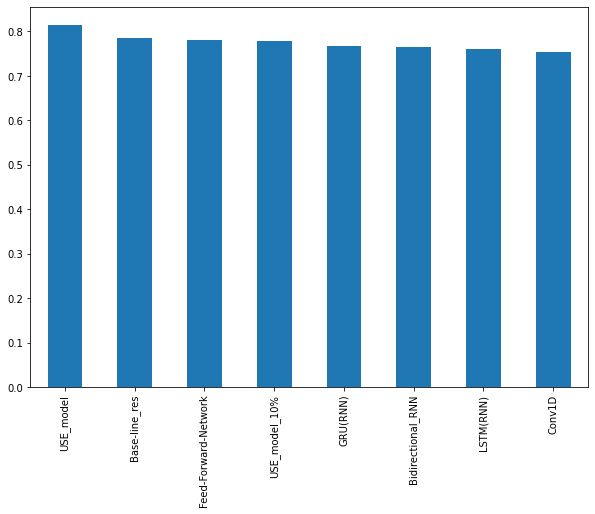

In [176]:
# sort the results by the f1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

In [179]:
!tensorboard dev upload --logdir ./MODEL_LOGS/ \
  --name "NLP reference notes" \
  --description "Models for the NLP reference notes" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./MODEL_LOGS/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=cF12KuErdsDJBHmSOlDhKE9uJcNpmC&prompt=consent&access_type=offline

In [180]:
# https://tensorboard.dev/experiment/zl76idvGRhGHegAs3l6RBg/ 

In [181]:
!tensorboard dev list

https://tensorboard.dev/experiment/zl76idvGRhGHegAs3l6RBg/
	Name                 NLP reference notes
	Description          Models for the NLP reference notes
	Id                   zl76idvGRhGHegAs3l6RBg
	Created              2022-08-15 07:49:59 (4 minutes ago)
	Updated              2022-08-15 07:50:09 (4 minutes ago)
	Runs                 20
	Tags                 5
	Scalars              300
	Tensor bytes         0
	Binary object bytes  5862667
https://tensorboard.dev/experiment/F4Bvtx8GS96dLRRzK47b7Q/
	Name                 Resnet50V2 vs EfficientnetB0
	Description          Results regarding feature extraction tool
	Id                   F4Bvtx8GS96dLRRzK47b7Q
	Created              2022-07-30 08:27:59
	Updated              2022-07-30 08:28:26
	Runs                 20
	Tags                 5
	Scalars              300
	Tensor bytes         0
	Binary object bytes  22233264
Total: 2 experiment(s)


In [205]:
model_6_preds = model_6.predict(val_sentences)
# model_pred_probs = tf.squeeze(tf.round(model_6_preds))
model_6_preds_probs = tf.squeeze(tf.round(model_6_preds))

val_df = pd.DataFrame({
    "text": val_sentences,
    "target": val_labels,
    "pred": model_6_preds_probs,
    "prediction_prob": tf.squeeze(model_6_preds)})

val_df.head()


,text,target,pred,prediction_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.193330
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.768968
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987822
3,@camilacabello97 Internally and externally scr...,1,0.0,0.212709
4,Radiation emergency #preparedness starts with ...,1,1.0,0.759741


In [206]:
# Find thw wrong predictions and sort by the prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred")

In [207]:
most_wrong[:10]

,text,target,pred,prediction_prob
345,How to prepare your #property for a #storm:\n\...,1,0.0,0.178422
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.076918
586,World War II book LIGHTNING JOE An Autobiograp...,1,0.0,0.137461
333,The date for the release of EP03 DESOLATION is...,1,0.0,0.221382
603,Tension In Bayelsa As Patience Jonathan Plans ...,1,0.0,0.490589
613,Stupid women nearly collided into me today aft...,1,0.0,0.236263
306,@Zak_Bagans this is Sabrina my dad rescued her...,1,0.0,0.103515
617,#Metepec #Mexico - ?NIGHT DISASTER?...E(Oficia...,1,0.0,0.380915
296,Would a paramedic really do that? Leave someon...,1,0.0,0.282105
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.067803


In [208]:
"""
0 -- not disaster 
1 -- disaster
"""

'\n0 -- not disaster \n1 -- disaster\n'

In [209]:
most_wrong.tail()

,text,target,pred,prediction_prob
299,@LegacyOfTheSith @SagaciousSaber @Lordofbetray...,0,1.0,0.553882
291,He made such a good point. White person coming...,0,1.0,0.563367
285,@Azimel 'Screaming Mad Scientist deceased afte...,0,1.0,0.628614
759,FedEx will no longer transport bioterror patho...,0,1.0,0.882016
760,Crack in the path where I wiped out this morni...,0,1.0,0.657533


In [212]:
# checking the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prediction_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {prediction_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.17842212319374084
Text:
How to prepare your #property for a #storm:

http://t.co/KhYqQsi6My http://t.co/G6Vs3XEinb

----

Target: 1, Pred: 0.0, Prob: 0.07691830396652222
Text:
@reriellechan HE WAS THE LICH KING'S FIRST CASUALTY BLOCK ME BACK I HATE YOU! http://t.co/0Gidg9U45J

----

Target: 1, Pred: 0.0, Prob: 0.13746079802513123
Text:
World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/R4khEH7iaf http://t.co/qSZgJfUutu

----

Target: 1, Pred: 0.0, Prob: 0.22138193249702454
Text:
The date for the release of EP03 DESOLATION is set. Stay tuned for more info while we finalise the schedule. #alt #electro #rock #comingsoon

----

Target: 1, Pred: 0.0, Prob: 0.49058860540390015
Text:
Tension In Bayelsa As Patience Jonathan Plans To Hijack APC PDP http://t.co/epABiNcZmJ http://t.co/1SgzGtgfw9

----

Target: 1, Pred: 0.0, Prob: 0.23626261949539185
Text:
Stupid women nearly collided into me today after she came out of a junctio

In [213]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [215]:
# Visualizing the predictions on the test sentences
test_sentences = test_df["text"].to_list() 
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob =  tf.squeeze(model_6.predict([test_sample]))
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----------\n")

Pred: 0, Prob: 0.08563181012868881
Text:
?????? FREE!!! ÛÏThis book will blow your mindÛ_Û ??????

'Suspense danger anger love and (most importantly)... http://t.co/nzN5nTPn75

-----------

Pred: 0, Prob: 0.3286467492580414
Text:
The move Saturday --&gt; #Mirage! 400 N. West st. Raleigh NC 21+ http://t.co/bXdaTWjNHS Tickets at: http://t.co/7hAnPcr5rK

-----------

Pred: 0, Prob: 0.7717787027359009
Text:
#Fracking #Ecocide Eyewitness to Extreme Weather: 11 Social Media Posts that Show Just How Crazy T... http://t.co/dEdDH8Rme8 #Revolution

-----------

Pred: 0, Prob: 0.25101813673973083
Text:
'Behold your house is being left to you desolate!' (Matthew 23:38 NASB)

-----------

Pred: 0, Prob: 0.26705846190452576
Text:
@st3ph007 do you think the pedagogy/practice is more important than the environment? #BFC630NZ walls can be 'flattened' in many ways

-----------

Pred: 0, Prob: 0.669942319393158
Text:
Be safe and be prepare from emergency kits to evacuation. Alertness esp women and ch

In [216]:
# Speed/Score tradeoff

In [217]:
import time

def prediction_timer(model, samples):
  start =  time.perf_counter()
  model.predict(samples)
  end = time.perf_counter()
  total_time = end-start 
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [219]:
model_6_total_pred_time, model_6_time_per_pred = prediction_timer(model=model_6,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.8883599649998359, 0.0011658267257215694)

In [221]:
baseline_total_pred_time, baseline_total_per_pred = prediction_timer(model=model_0,
                                                                     samples=val_sentences)
baseline_total_pred_time , baseline_total_per_pred

(0.07933067900012247, 0.00010410850262483264)

Text(0, 0.5, 'F1 score')

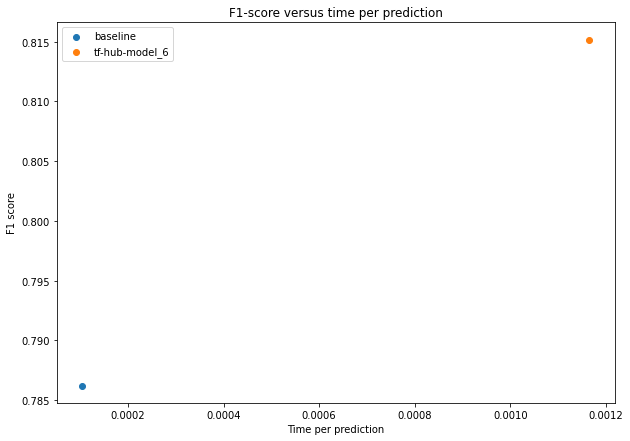

In [224]:
# Visualizing time
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_total_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_res["f1"], label="tf-hub-model_6")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1 score")